In [1]:
from matplotlib import pyplot as plot
import numpy as np
from numba import cuda, njit, vectorize,float32,int32
import math
import cupy
import tqdm.notebook as tq
from time import perf_counter_ns

We prepare a function that writes the output in LAMMPS format:

In [2]:
#function that writes the output into lammps format
def writelammps(filename, Lx, Ly, Lz, TIMESTEP, r, v): #r,v are numpy arrays
    #WRITELAMMPS Write data to lammps file
    with open(filename, 'a') as fp:
        ip = len(r)
        fp.write('ITEM: TIMESTEP\n')
        fp.write(f'{TIMESTEP}\n')
        fp.write('ITEM: NUMBER OF ATOMS\n')
        fp.write(f'{ip}\n') # Nr of atoms
        fp.write('ITEM: BOX BOUNDS pp pp pp\n')
        fp.write(f'{0.0} {Lx}\n') #box size, x
        fp.write(f'{0.0} {Ly}\n')
        fp.write(f'{0.0} {Lz}\n')
        fp.write('ITEM: ATOMS id type x y z vx vy vz\n')
        for i in range(0,ip):
            fp.write(f'{i} {1} {r[i][0]} {r[i][1]} {r[i][2]} {v[i][0]} {v[i][1]} {v[i][2]}\n')

Prepare the initial system:

In [3]:
def init_lattice(L=5):
    #L = 5 # Lattice size
    b = 2.0 # Size of unit cell (units of sigma)
    v0 = 1.0 # Initial kinetic energy scale
    N=4 * L**3 # Nr of atoms
    r = np.zeros((N,3))
    r0 = b * np.array(np.meshgrid(np.arange(L), np.arange(L), np.arange(L))).T.reshape(-1, 3)
    # Generate velocities: uniform destribution
    v = v0 * (0.5 - np.random.rand(N,3))
    bvec = np.array([[0, 0, 0], [b/2, b/2, 0], [b/2, 0, b/2], [0, b/2, b/2]])
    ip = 0
    # Generate lattice positions
    for ix in range(0,L):
        for iy in range(0,L):
            for iz in range(0,L):
                for k in range(0,4):
                    r[ip] = r0[ix*L**2+L*iy+iz] + bvec[k]
                    ip = ip + 1 # Add particle
    Lx = L*b
    Ly = L*b
    Lz = L*b
    return r, v, Lx, Ly, Lz
# Output to file
#writelammps('mymdinit.lammpstrj',L*b,L*b,L*b, 0, r,v)


In [4]:
# A generic Lennard Jones potential
@njit
def LJ_potential(dr):
    rr = np.dot(dr,dr)
    return -24*(2*(1/rr)**6-(1/rr)**3)*dr/rr

#velocity verlet 
@njit
def velocity_verlet(L, r):
    N = len(r)
    a = np.zeros((N,3)) # Store calculated accelerations
    for i1 in range(0, N):
        for i2 in range(i1+1, N):
            dr = r[i1] - r[i2]
            for k in range(0,3): #Periodic boundary conditions
                if dr[k] > L[k]/2:
                    dr[k] = dr[k] - L[k]
                elif dr[k] < -L[k]/2:
                    dr[k] = dr[k] + L[k]
            aa = LJ_potential(dr)
            a[i1] += aa # from i2 on i1
            a[i2] -= aa # from i1 on i2
    return a

# Periodic boundary conditions
@njit
def periodic_boundary(L, r):
    N = len(r)
    for i1 in range(0, N): 
        for k in range(0,3):
            if (r[i1][k]>L[k]):
                r[i1][k] = r[i1][k] - L[k]
            if (r[i1][k]<0):
                r[i1][k] = r[i1][k] + L[k]
    return r

In [5]:
def integrator(r, v, Lx, Ly, Lz, Dump_file,t = 3.0, dt = 0.001, dump_iter=10): 
    ''' Input_file : string
        Dump_file  : string'''
    L = [Lx, Ly, Lz] 
    N = len(r) 
    n = int(np.ceil(t/dt))
    for i in tq.tqdm(range(1,n)): # Loop over timesteps
        # first half of the velocity verlet
        a = velocity_verlet(L, r)
        v = v + a*dt/2;
        r = r + v*dt/2
        # Periodic boundary conditions
        r = periodic_boundary(L, r)
        #second half of velocity verlet            
        a = velocity_verlet(L, r)
        v = v + a*dt/2;
        if i%dump_iter == 0 or i == (n-1):
            writelammps(Dump_file, Lx, Ly, Lz, i*dt, r, v);

In [6]:
@cuda.jit(device=True)
def LJ_potential_gpu(dr, aa):
    rr = dr[0]**2 + dr[1]**2 + dr[2]**2
    for i in range(3):
        aa[i] = -24*(2*(1/rr)**6-(1/rr)**3) * dr[i] / rr

@cuda.jit(debug=True)
def velocity_verlet_gpu(aa, dt_gpu, L_gpu, r_gpu, dr_gpu, a_gpu, v_gpu):
    start_x = cuda.grid(1)
    stride_x = cuda.gridsize(1)
    tid = start_x
    for i1 in range(start_x, r_gpu.shape[0], stride_x):
        for k in range(3):
            a_gpu[i1][k] = 0;
        for i2 in range(i1+1, r_gpu.shape[0]):
            for k in range(0,3): #Periodic boundary conditions
                dr_gpu[i1][k] = r_gpu[i1][k] - r_gpu[i2][k]
                if dr_gpu[i1][k] > L_gpu[k]/2:
                    dr_gpu[i1][k] = dr_gpu[i1][k] - L_gpu[k]
                elif dr_gpu[i1][k] < -L_gpu[k]/2:
                    dr_gpu[i1][k] = dr_gpu[i1][k] + L_gpu[k]
            LJ_potential_gpu(dr_gpu[i1], aa[i1])
            for k in range(3):
                cuda.atomic.add(a_gpu, (i1, k), aa[i1][k])
                cuda.atomic.sub(a_gpu, (i2, k), aa[i1][k])

@cuda.jit
def update_velocity_gpu(v_gpu, a_gpu, dt_gpu):
    start_x = cuda.grid(1)
    stride_x = cuda.gridsize(1)
    tid = start_x
    for i1 in range(start_x, v_gpu.shape[0], stride_x):
        for k in range(3):
            v_gpu[i1][k] += a_gpu[i1][k] * dt_gpu[()]/2;

@cuda.jit
def periodic_boundary_gpu(dt_gpu, L_gpu, v_gpu, r_gpu):
    start_x = cuda.grid(1)
    stride_x = cuda.gridsize(1)
    tid = start_x
    for i1 in range(start_x, r_gpu.shape[0], stride_x):
        for k in range(0,3):
            r_gpu[i1][k] += v_gpu[i1][k] * dt_gpu[()]/2
            if r_gpu[i1][k] > L_gpu[k]:
                r_gpu[i1][k] = r_gpu[i1][k] - L_gpu[k]
            if r_gpu[i1][k] < 0:
                r_gpu[i1][k] = r_gpu[i1][k] + L_gpu[k]

In [7]:
def integrator_gpu(r, v, Lx, Ly, Lz, Dump_file,t = 3.0, dt = 0.001, dump_iter=10): 
    ''' Input_file : string
        Dump_file  : string'''
    L = np.array([Lx, Ly, Lz])
    n = int(np.ceil(t/dt))
    
    dt_gpu = cuda.to_device(np.float32(dt))
    L_gpu = cuda.to_device(np.float32(L))
    r_gpu = cuda.to_device(np.float32(r))
    a_gpu = cuda.device_array(v.shape, dtype=np.float32) # Store calculated accelerations
    v_gpu = cuda.to_device(np.float32(v)) # Store calculated speeds
    dr_gpu = cuda.device_array(v.shape, dtype=np.float32) # Store calculated dr
    aa = cuda.device_array(v.shape, dtype=np.float32) 
    
    blocks = 128
    threads_per_block = 128
    
    for i in tq.tqdm(range(1,n)): # Loop over timesteps
        # first half of the velocity verlet
        velocity_verlet_gpu[blocks, threads_per_block](aa, dt_gpu, L_gpu, r_gpu, dr_gpu, a_gpu, v_gpu)
        cuda.synchronize()
        update_velocity_gpu[blocks, threads_per_block](v_gpu, a_gpu, dt_gpu)
        cuda.synchronize()
        # Periodic boundary conditions
        periodic_boundary_gpu[blocks, threads_per_block](dt_gpu, L_gpu, v_gpu, r_gpu)
        cuda.synchronize()
        #second half of velocity verlet            
        velocity_verlet_gpu[blocks, threads_per_block](aa, dt_gpu, L_gpu, r_gpu, dr_gpu, a_gpu, v_gpu)
        cuda.synchronize()
        update_velocity_gpu[blocks, threads_per_block](v_gpu, a_gpu, dt_gpu)
        cuda.synchronize()
        if i%dump_iter == 0 or i == (n-1):
            writelammps(Dump_file, Lx, Ly, Lz, i*dt, r_gpu.copy_to_host(), v_gpu.copy_to_host());

In [8]:
r, v, Lx, Ly, Lz = init_lattice(6); L = np.array([Lx, Ly, Lz])

In [9]:
init = perf_counter_ns()
integrator( r, v, Lx, Ly, Lz, 'mymddump.lammpstrj', t = 1, dt = 0.01)
total_cpu = perf_counter_ns() - init

  0%|          | 0/99 [00:00<?, ?it/s]

C:\Users\arash\anaconda3\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'L' of function 'velocity_verlet'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\AppData\Local\Temp\ipykernel_21284\3146313584.py", line 8:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\arash\anaconda3\lib\site-packages\numba\core\ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'L' of function 'periodic_boundary'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\AppData\Local\Temp\ipykernel_21284\3

Check what cuda device is being used:

In [10]:
cuda.get_current_device().name

b'NVIDIA GeForce RTX 3070 Laptop GPU'

In [11]:
init = perf_counter_ns()
integrator_gpu( r, v, Lx, Ly, Lz, 'mymddump_gpu.lammpstrj', t = 1, dt = 0.01)
total_gpu = perf_counter_ns() - init

  0%|          | 0/99 [00:00<?, ?it/s]

In [12]:
print(f'Total speedup: {total_cpu/total_gpu}')

Total speedup: 3.6262130135193957


I am now going to measure the execution time for cpu and gpu while changing the number of atoms:

In [15]:
cpu_time = []
gpu_time = []
number_atoms = []
for l in range(3, 10):
    r, v, Lx, Ly, Lz = init_lattice(l); L = np.array([Lx, Ly, Lz])
    number_atoms.append(len(r))
    
    init = perf_counter_ns()
    integrator( r, v, Lx, Ly, Lz, 'mymddump.lammpstrj', t = 1, dt = 0.01)
    total_cpu = perf_counter_ns() - init
    cpu_time.append(total_cpu)
    
    init = perf_counter_ns()
    integrator_gpu( r, v, Lx, Ly, Lz, 'mymddump_gpu.lammpstrj', t = 1, dt = 0.01)
    total_gpu = perf_counter_ns() - init
    gpu_time.append(total_gpu)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

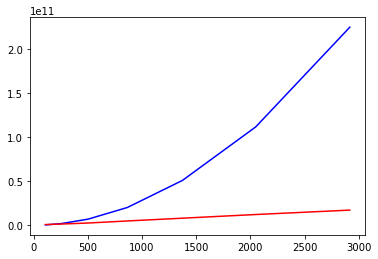

In [16]:
plot.plot(number_atoms, cpu_time, 'b') # CPU time in nano seconds
plot.plot(number_atoms, gpu_time, 'r') # GPU time in nano seconds